# Stock-Predictor using LSTM

# Overview

This workbook will explore the possibility of analysing time-series data in the form of stock prices in order to predict future growth or decline. For this purpose, a Long-Short Term Memory (LSTM) methodology will be adopted. The methodology will use a user-defined set of consecutive days that will train a model to predict the following days' closing price. In order to do that, the model will be trained on readily provided data from **Yahoo finance api** in conjunction with additional features added to increase the model accuracy. Finally, different time-frames of look-backs will be compared to each other, in the attempt to find the most optimal solution.

For the purpose of this analysis, data for **Google** will be used imported using **Yahoo finance api**

### Import libraries

In [1]:
import datetime as dt
from finta import TA

import pandas as pd
from pandas_datareader import data as web
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from numpy import size
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 

np.warnings.filterwarnings('ignore')

### Load data and pre-processing

In [2]:
def get_stock_data(symbol, start_date, end_date):
    '''
    download stock data over from yahoo api form start date to end date
    input
        stock - String representing stock symbol eg APPL
        start - datetime object represent start date; default Jan 1, 2010
        end - datetime object represent end date; default: Jan 1, 2020
    output
        historical stock data pulled from yahoo finance stock api from start to end dates
    '''
    stockData = web.DataReader(symbol, 'yahoo', start_date, end_date)
    
    return stockData

start_date = dt.datetime(2004, 10, 1)
end_date = dt.datetime(2022, 10, 1)
df_GOOG = get_stock_data('GOOG',start_date, end_date)
df_GOOG.tail(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-27,100.459999,97.339996,99.910004,98.089996,24225000.0,98.089996
2022-09-28,101.400002,97.800003,98.019997,100.739998,24617000.0,100.739998
2022-09-29,99.300003,96.519997,99.300003,98.089996,21921500.0,98.089996
2022-09-30,99.494003,96.029999,97.730003,96.150002,26248200.0,96.150002


In [3]:
#Renaming columns
df_GOOG.rename(columns = {'High':'high', 'Low': 'low', 'Open':'open','Volume':'volume', 'Adj Close':'adj_close'}, inplace = True)

### Adding features

Additional features were added in order to increase the accuracy of the prediction. The features are in the form of technical indicators used to measure the performance of the stock in various ways. There are different types of technical indicators, namely: **trend, momentum, volatility and volume**. 

For best results, it is advised to use a mixture of techincal indicators. Otherwise, using many indicators of the same type will result in **multicollinearity**, overblowing the results

In this analysis the following techincal indicators were chosen:

Relative Strength Index (RSI) - Used as a momentum indicator commonly used to determine the strength of price changes in market. 

On Balance Volume - Used as a volume indicator, calculating the buying and selling pressures of a stock

Bollinger Bands -  Used as a volatility and trend indicator, plots three trend lines, determining whether a stock is overbought or oversold.

In [4]:
rsi = TA.RSI(df_GOOG)
obv = TA.OBV(df_GOOG)
bbands = TA.BBANDS(df_GOOG, 21)

df_GOOG['OBV'] = obv.values
df_GOOG = pd.concat([df_GOOG, rsi], axis = 1)
df_GOOG = pd.concat([df_GOOG, bbands], axis = 1)
df_GOOG = df_GOOG.dropna()
df_GOOG.describe()

,high,low,open,Close,volume,adj_close,OBV,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
count,4511.000000,4511.000000,4511.000000,4511.000000,4.511000e+03,4511.000000,4.511000e+03,4511.000000,4511.000000,4511.000000,4511.000000
mean,37.576318,36.823572,37.200643,37.205834,1.227037e+08,37.205834,2.016020e+10,54.217064,39.072900,36.990104,34.907309
std,35.182853,34.445349,34.809058,34.815612,1.505469e+08,34.815612,3.846793e+09,12.633815,36.664160,34.684090,32.755789
min,4.221676,4.017691,4.096396,4.112087,1.584340e+05,4.112087,-8.102176e+08,21.330543,4.602334,3.816469,2.743964
25%,12.826547,12.538752,12.695290,12.676859,3.014000e+07,12.676859,1.919959e+10,44.767545,13.464443,12.686246,11.697362
50%,23.112617,22.821959,23.021212,22.988832,6.859214e+07,22.988832,2.112246e+10,53.936424,23.350873,22.487651,21.638335
75%,53.558750,52.362125,52.915998,53.011000,1.530796e+08,53.011000,2.180190e+10,63.436345,55.625090,52.866928,50.030339
max,152.100006,149.887497,151.863495,150.709000,1.650833e+09,150.709000,2.668921e+10,90.929456,154.074570,147.882762,144.401245


### Visualizing the data

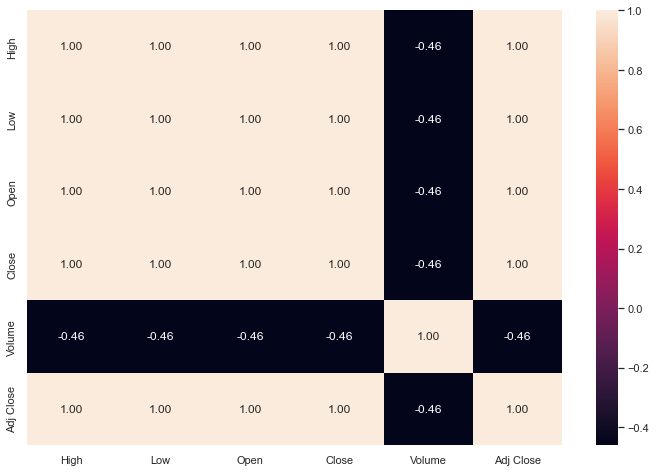

In [4]:
sns.set (rc = {'figure.figsize':(12, 8)})
sns.heatmap(df_GOOG.corr(), annot=True,fmt='.2f');

As expected most variables are highly correlated to each other. Exceptions are made by the RSI, which is understandable given that it is more linked to the future price rather than the current one.

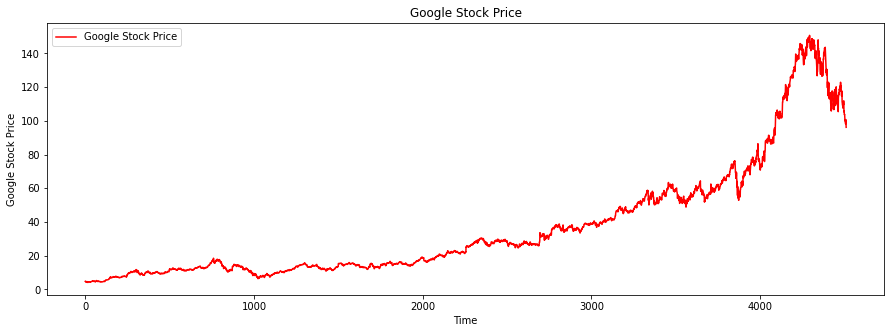

In [5]:
# Visualising the results
plt.figure(2, figsize=(15,5))
plt.plot(df_GOOG.loc[:, ['adj_close']].values, color = "red", label = "Google Stock Price")
plt.title('Google Stock Price')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

As it can be seen, the stock follows a steady increase, before the events in 2020, where it had a sharp decline, followed by a rapid growth. This time-frame will be discussed in greater detail later in the notebook

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	'''
	A method for preprocessing arrays for LSTM modelling. The sequence will be split into two:
	- A tensor containing groups of all the variables of a user-defined set of time-steps before the price to be predicted
	- A matrix containing the prices to be predicted

	Args:
	-sequences - the sequence to be pre-processed
	-n_steps - user-defined time-steps before the predicted price

	Output:
	X - the tensor
	y - the matrix 
	'''

	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)



# Lag model

For the purpose of this analysis, only a lag model will be observed. What this implies is that each group of variables will be looking to predict the next day price. This allows the model to have some variability and not teaching it on predicting same day data.

In [8]:
def data_preprocessing(df, days_prior, split):
    '''
    Description:
    A method to pre-process a given dataframe to be ready for LSTM analysis. The process includes:
    - Splitting the dataset into training and test into a pre-determined ratio
    - Normalizing both datasets
    - Converting each dataset into a tensor, looking back to the specified amount of days
    - Defining an inverse normalizer feature for later in the analysis

    Inputs:
    df - the dataframe to be pre-processed
    days_prior - the days to look back to
    split - the ratio split of test and train

    Outputs
    X_train - Predictive variables train set 
    X_test - Predictive variables train set
    y_train - Predicted variable train set
    y_test - Predicted variable test set
    y_test_norm - normalized features for actual prices
    split_index - the index in the daframe where the split is occurring
    days_prior - the time-step

    '''

    #Reseting index and removing unnecessary columns
    df = df.reset_index()
    df = df.drop(['Date'], axis=1)


    #Calculate the index of split
    split_index = int(df.shape[0] * split)

    df = df.reindex(columns=['high', 'low', 'open', 'Close', 'volume', 'OBV', '14 period RSI', 'BB_UPPER', 
                                'BB_MIDDLE', 'BB_LOWER', 'adj_close'])
    #Split data
    train_data = df[:split_index]
    test_data = df[split_index:]

    #Normalize the variables
    normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
    #Creating a specific scaler for the y values
    y_normaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
    #Normalizing the training dataset by using fit_transform
    train_normalised = normaliser.fit_transform(train_data)
    #Splitting the normalized set into X_train and y_train
    X_train, y_train = split_sequences(train_normalised, days_prior)

    #Applying the trained normalizer to transform the test data
    test_normalised = normaliser.transform(test_data)

    #Splitting test data into X_test and y_test
    X_test, y_test = split_sequences(test_normalised, days_prior)

    #Training a normalizer on the y values only
    y_norm = y_normaliser.fit_transform(train_data.loc[:, ['adj_close']].values)
    y_test_norm = y_normaliser.transform(test_data.loc[:, ['adj_close']].values)

    return X_train, X_test, y_train, y_test, y_test_norm, split_index, days_prior
    


In [9]:
def build_lstm(X_train, y_train):

    
    '''
    A method to train an LSTM model using 4 LSTM layers, 1 Dense layer and a relu activation function

    Args:
    X_train - training variables
    y_train - training prices

    Output:
    model - a trained LSTM model used for predicting y_test
    '''
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 10)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 70))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('relu'))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs = 25, batch_size = 32)

    return model


##### Looking back 21 days

The first model will look at the previous 3 weeks in order to predict the next days' price

In [10]:
X_train, X_test, y_train, y_test, y_test_norm, split_index, days_prior = data_preprocessing(df_GOOG, 21, 0.7)
model = build_lstm(X_train, y_train)
predicted_stock_price = model.predict(X_test)


Epoch 1/25
99/99 [==============================] - 8s 27ms/step - loss: 0.0067
Epoch 2/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0021
Epoch 3/25
99/99 [==============================] - 3s 25ms/step - loss: 0.0016
Epoch 4/25
99/99 [==============================] - 3s 26ms/step - loss: 0.0016
Epoch 5/25
99/99 [==============================] - 2s 24ms/step - loss: 0.0015
Epoch 6/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0027
Epoch 7/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0012
Epoch 8/25
99/99 [==============================] - 3s 25ms/step - loss: 0.0011
Epoch 9/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0011
Epoch 10/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0022
Epoch 11/25
99/99 [==============================] - 2s 25ms/step - loss: 0.0012
Epoch 12/25
99/99 [==============================] - 2s 25ms/step - loss: 8.9086e-04
Epoch 13/25
99/99 [==============

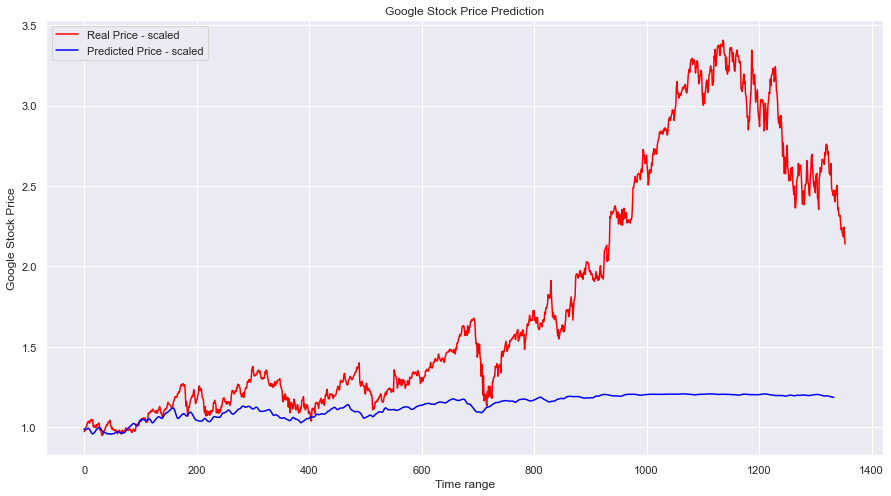

0.9545365718848392


In [11]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(y_test_norm, color = "red", label = "Real Price - scaled")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Price - scaled")
plt.title('Google Stock Price Prediction - 21-day look-back')
plt.xlabel('Time range')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
print("Mean absolute error of {0}".format(mean_squared_error(y_test_norm[:-20], predicted_stock_price, squared = False)))

Even though the MSE of the model is at 96, it can be seen that it has done a relatively decent job at predicting the direction at which the stock is going. However, technical indicators have performed relatively well up until the drop in 2020. Afterwards, it can be observed that the techincal indicators lose track of the rapid increase of stock. This serves as proof that there are other factors influencing the rise of the stock - either other technical indicators or external factors like media hype, FOMO etc.

# Attempting different configurations

#### Looking back 7 and 50 days

In [12]:
X_train_7, X_test_7, y_train_7, y_test_7, y_test_norm_7, split_index, days_prior = data_preprocessing(df_GOOG, 7, 0.7)
model_7 = build_lstm(X_train_7, y_train_7)
predicted_stock_price_7 = model_7.predict(X_test_7)

Epoch 1/25
99/99 [==============================] - 6s 12ms/step - loss: 0.0118
Epoch 2/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 3/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 4/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 5/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 6/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 7/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0011
Epoch 8/25
99/99 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 9/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 10/25
99/99 [==============================] - 1s 12ms/step - loss: 9.4632e-04
Epoch 11/25
99/99 [==============================] - 1s 12ms/step - loss: 0.0010
Epoch 12/25
99/99 [==============================] - 1s 12ms/step - loss: 9.7206e-04
Epoch 13/25
99/99 [==========

In [13]:
X_train_50, X_test_50, y_train_50, y_test_50, y_test_norm_50, split_index, days_prior = data_preprocessing(df_GOOG, 50, 0.7)
model_50 = build_lstm(X_train_50, y_train_50)
predicted_stock_price_50 = model_50.predict(X_test_50)

Epoch 1/25
98/98 [==============================] - 11s 55ms/step - loss: 0.0059
Epoch 2/25
98/98 [==============================] - 6s 59ms/step - loss: 0.0017
Epoch 3/25
98/98 [==============================] - 6s 64ms/step - loss: 0.0014
Epoch 4/25
98/98 [==============================] - 6s 65ms/step - loss: 0.0014
Epoch 5/25
98/98 [==============================] - 6s 62ms/step - loss: 0.0013
Epoch 6/25
98/98 [==============================] - 6s 66ms/step - loss: 0.0012
Epoch 7/25
98/98 [==============================] - 6s 63ms/step - loss: 0.0014
Epoch 8/25
98/98 [==============================] - 6s 62ms/step - loss: 0.0012
Epoch 9/25
98/98 [==============================] - 6s 62ms/step - loss: 0.0011
Epoch 10/25
98/98 [==============================] - 6s 62ms/step - loss: 9.3813e-04
Epoch 11/25
98/98 [==============================] - 6s 61ms/step - loss: 9.4177e-04
Epoch 12/25
98/98 [==============================] - 6s 62ms/step - loss: 0.0012
Epoch 13/25
98/98 [=========

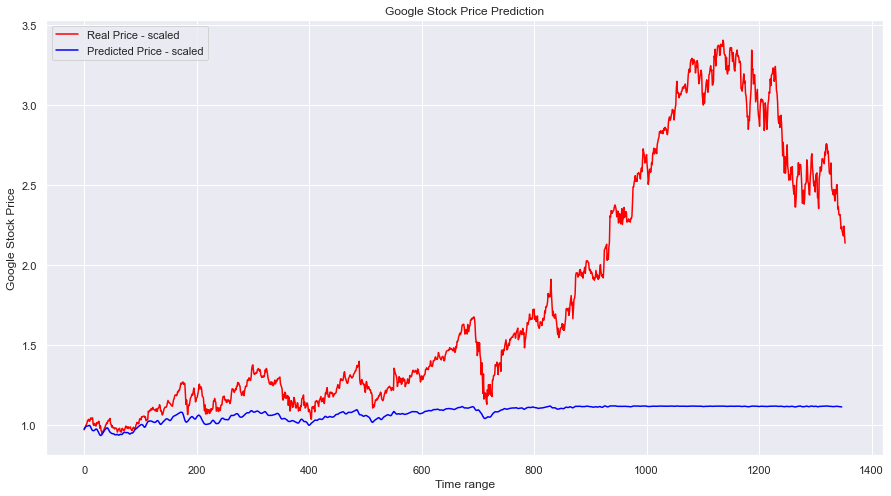

1.0092502779166455


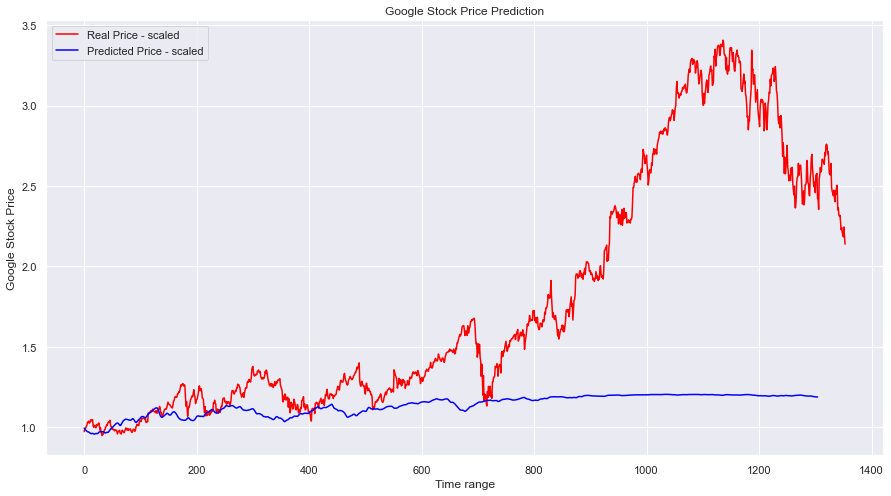

0.9430771265984526


In [15]:
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(y_test_norm_7, color = "red", label = "Real Price - scaled")
plt.plot(predicted_stock_price_7, color = "blue", label = "Predicted Price - scaled")
plt.title('Google Stock Price Prediction - 7 day look-back')
plt.xlabel('Time range')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
print("Mean absolute error of {0}".format(mean_squared_error(y_test_norm_7[:-6], predicted_stock_price_7, squared = False)))

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(y_test_norm_50, color = "red", label = "Real Price - scaled")
plt.plot(predicted_stock_price_50, color = "blue", label = "Predicted Price - scaled")
plt.title('Google Stock Price Prediction - 50-day look-back')
plt.xlabel('Time range')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
print("Mean absolute error of {0}".format(mean_squared_error(y_test_norm_50[:-49], predicted_stock_price_50, squared = False)))

From the graphs above, it can be seen that the 7-day model follows a similar trend to the 21-day one. However, it has a higher mean square error, making it slightly worse than the 21-day model. The 50-day model on the other hand provides us with a better mean square error than the 21-day. It can, however, be seen that the predicted line does not follow the trend as well as the in the 21-day model, lagging behind a lot. The higher mean square error could be a result of the blue line having more overlapping parts with the red line. As it can be seen, however, that does not result in a better model. 

Those 3 cases were further tested with different configurations of the LSTM model, including a different number of LSTM layers, dense layers, though it did not provide better results. Different activation functions were also tested and it was concluded that 'relu' performs the best out of the available. LSTM units and epochs were increased in size, however the increases in accuracy were marginal.

# References

https://www.investopedia.com/terms/t/technicalindicator.asp

https://www.investopedia.com/articles/trading/12/using-trading-indicators-effectively.asp#toc-the-bottom-line

https://www.investopedia.com/terms/t/technicalindicator.asp

https://www.brokerxplorer.com/article/bollinger-bands-and-rsi-combo-strategy-2290